### Visualize the Cn2 Map

In [18]:
import numpy as np
import cv2
from glob import glob
from PIL import Image
from tqdm import tqdm 
import matplotlib.pyplot as plt
from skimage import color
from matplotlib.ticker import FuncFormatter
from skimage.feature import match_template
plt.rcParams['figure.figsize'] = [15, 8]

In [19]:
def imgradient(img):
    if type(img) != np.ndarray:
        img = img.convert('L')
        img = np.asarray(img)

    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Gx = cv2.filter2D(img, -1, sobel_x)
    Gy = cv2.filter2D(img, -1, sobel_y)
    grad_mag = np.sqrt(Gx**2 + Gy**2)
    return grad_mag

### Define your parameters/Input


In [40]:
focal_length, fstop = 0.5, 8.000
D, ImageScalledDown, lambda_temp, L = focal_length/fstop, 3, 500E-9, 2789
dx, dy = ImageScalledDown*0.003208/1000, ImageScalledDown*0.003208/1000
PFOV, l_0, L_0 = dx/np.array(focal_length), 1 / 1000, 80
P = 2.914 if D < np.sqrt(lambda_temp * L) and l_0 <= D < L_0 else 1.1
print(f'{PFOV=}, {D=}, {L=}, {P=}')

# path = "Stabilized Road.mp4"
path = "I:/Turbulence Video Capture with Kylel/Metal Test V1/100NIKON/Stabilized/Metal Detection test.mp4"

# Read Video in from frame StartFrame to EndFrame, Keep it 60 frame for CNN
StartFrom = 7 # Seconds
EndAt = 10 # Seconds
doCrop = True
x, y, w, h = 540, 200, 512, 512
doStabilize = True

PFOV=1.9248000000000003e-05, D=0.0625, L=2789, P=1.1


### Load the video

In [41]:
cap = cv2.VideoCapture(path)

fps = cap.get(cv2.CAP_PROP_FPS)
NFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'{fps=}, {NFrames=}')


# Read Video in from frame StartFrame to EndFrame
stFrame = StartFrom*fps
endFrame = EndAt*fps

video = []
for i in tqdm(range(int(stFrame), int(endFrame))):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    if ret: 
        video.append(frame)
    else:
        break
cap.release()
video = np.array(video)

if doCrop:
    video = video[:, y:y+h, x:x+w, :]
else:
    video = video[:, :, :, :]

print(f'{video.shape=}')

fps=59.94005994005994, NFrames=1260


100%|██████████| 180/180 [00:12<00:00, 14.09it/s]


video.shape=(180, 512, 512, 3)


### Stabilize the Video

In [46]:
def stabilize(video_cube, MaxStb = 50, crop = False):
    # video_cube: 4D array of shape (n_frames, height, width, 3) or (n_frames, height, width)
    X_mov, Y_mov = [], []
    stabilized_video = np.empty_like(video_cube)
    ref_frame = video_cube[0]
    h, w = ref_frame.shape[:2]

    for i, current_frame in enumerate(tqdm(video_cube)):
        frame_Cropped = current_frame[MaxStb:-MaxStb, MaxStb:-MaxStb]

        # If the image is grayscale, use it directly. If not, convert to grayscale
        if len(ref_frame.shape) == 2: # grayscale
            ref_gray = ref_frame
            frame_gray = frame_Cropped
        else: # RGB
            ref_gray = cv2.cvtColor(ref_frame, cv2.COLOR_BGR2GRAY)
            frame_gray = cv2.cvtColor(frame_Cropped, cv2.COLOR_BGR2GRAY)

        # Perform template matching to get the shift
        match = match_template(ref_gray, frame_gray)
        y, x = np.unravel_index(np.argmax(match), match.shape) - np.array([MaxStb, MaxStb])

        # Store shifts and apply translation to current frame
        X_mov.append(x), Y_mov.append(y)
        M = np.float32([[1, 0, x], [0, 1, y]])
        stabilized_video[i] = cv2.warpAffine(current_frame, M, (w, h))

    if crop:
        max_x = max(X_mov)
        max_y = max(Y_mov)
        min_x = min(X_mov)
        min_y = min(Y_mov)

        # Crop the video based on max and min shifts
        stabilized_video = stabilized_video[:, max_y:-(abs(min_y)) if min_y != 0 else None, max_x:-(abs(min_x)) if min_x != 0 else None]
        # stabilized_video[:, max_y:-min_y if min_y != 0 else None, max_x:-min_x if min_x != 0 else None]

    return stabilized_video, X_mov, Y_mov

100%|██████████| 180/180 [01:17<00:00,  2.31it/s]


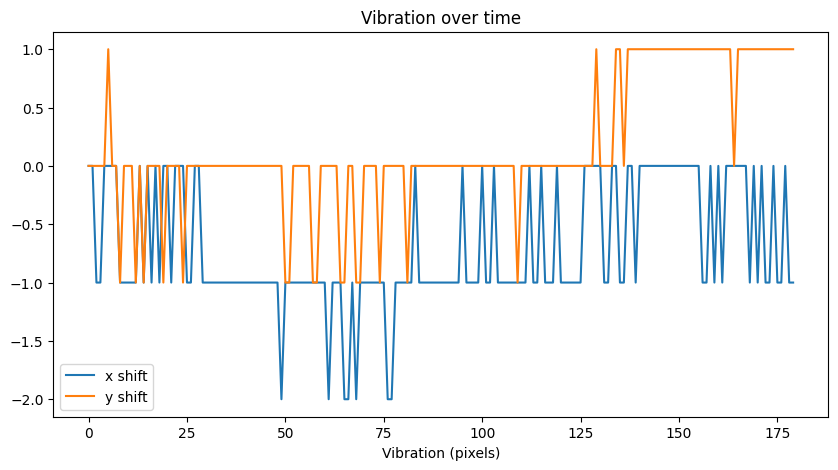

In [48]:
if doStabilize:
    video, X_mov, Y_mov = stabilize(video, MaxStb = 20, crop = doCrop)

    plt.figure(figsize = (10, 5))
    plt.plot(X_mov, label = 'x shift')
    plt.plot(Y_mov, label = 'y shift')
    plt.xlabel('Frame')
    plt.xlabel('Vibration (pixels)')
    plt.title('Vibration over time')
    plt.legend()
    plt.show()

### Estimate the $C_n^2$ Map

In [49]:
sigma_I = np.std(video, axis=0)
Grad_mag = imgradient(video[0])
Grad_mag[Grad_mag < Grad_mag.max()/100] = np.nan
Cn_sqr_mn = np.divide((np.dot(PFOV**2, D**(1/3)) * sigma_I**2), (Grad_mag*float(L)*float(P)))

# Get the mean of the Cn2 map - Not Essential
cn2_pred =  np.nanmean(Cn_sqr_mn)
print(f'{cn2_pred=}')

cn2_pred=2.8412104323036776e-13


### Visualize the $C_n^2$ Map

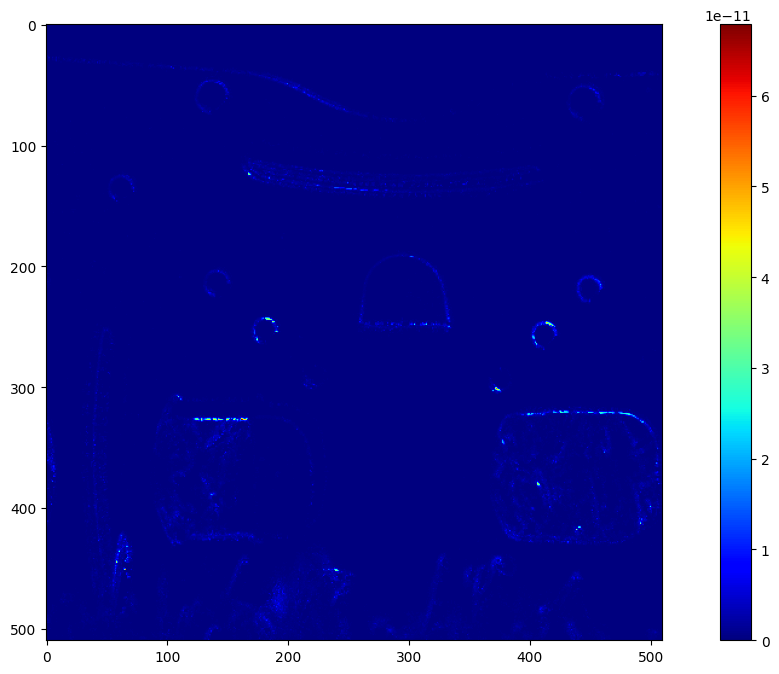

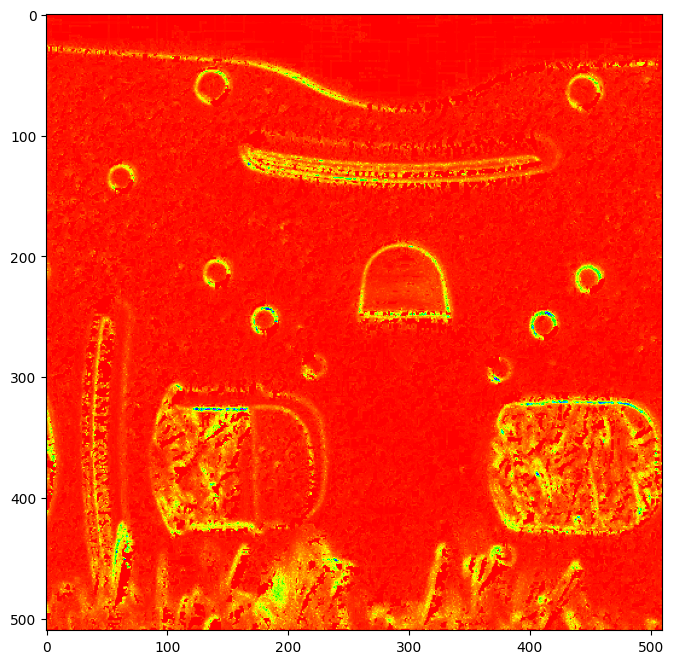

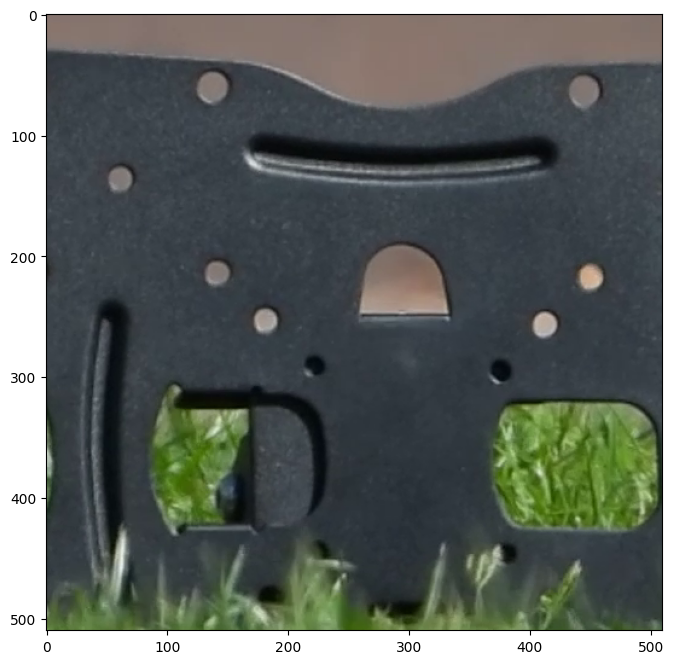

In [50]:
# Replace np.nan with 0
plt.rcParams['figure.figsize'] = [15, 8]
Cn_sqr_mnMap = np.nan_to_num(Cn_sqr_mn, nan=0)
Cn_sqr_mnMap = np.mean(Cn_sqr_mnMap, axis=2) # (1080, 1920)

Normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
plt.imshow((Cn_sqr_mnMap), cmap='jet'), plt.colorbar(), plt.show();

sq_Cn_sqr_mnMap = np.sqrt(Cn_sqr_mnMap)
plt.imshow(sq_Cn_sqr_mnMap, cmap='hsv'), plt.show();

plt.imshow(video[0][:,:,::-1]), plt.show();

### Overlay the $C_n^2$ Map on the Image

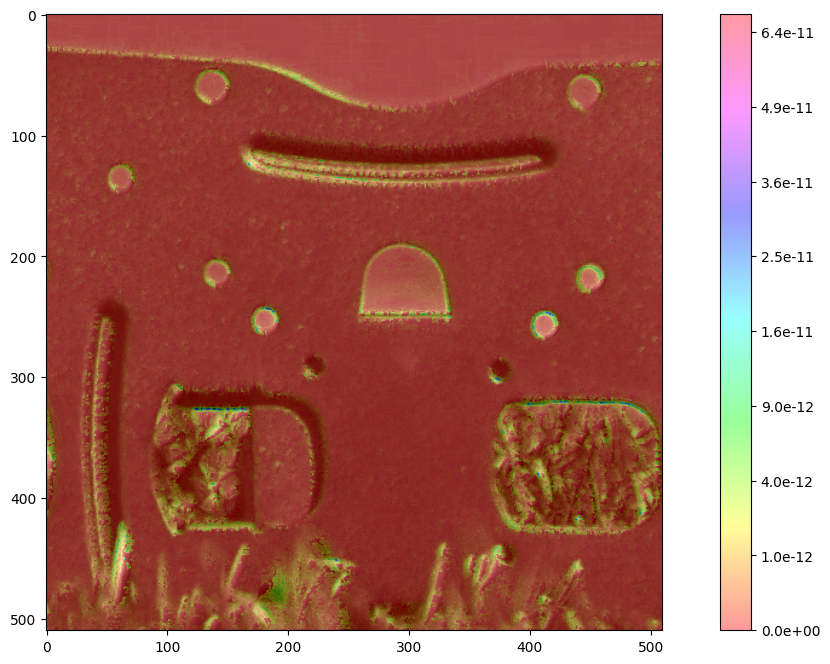

In [51]:
plt.figure(figsize=(15,8))
plt.imshow(video[0][:,:,0], cmap='gray')
plt.imshow(sq_Cn_sqr_mnMap, cmap='hsv', alpha=0.4, interpolation='bilinear')

cbar = plt.colorbar()
def square(x, pos):
    return '%0.1e' % (x ** 2)
formatter = FuncFormatter(square)
cbar.ax.yaxis.set_major_formatter(formatter)
plt.show()

### Create a video with Per Frame Gradient

In [52]:
cn2_pred = []

sigma_I = np.std(video, axis=0)
A = (np.dot(PFOV**2, D**(1/3)) * sigma_I**2)

for i in tqdm(range(len(video))):
    Grad_mag = imgradient(video[i])
    Grad_mag[Grad_mag < Grad_mag.max()/100] = np.nan
    B =  (Grad_mag*float(L)*float(P))
    Cn_sqr_mn = np.divide(A, B)
    cn2_pred.append(Cn_sqr_mn)

100%|██████████| 180/180 [00:06<00:00, 28.12it/s]


In [53]:
# Create the Overlay video and save it

frame_num, height, width, channels = video.shape

result = cv2.VideoWriter('MetalDetection_v1.avi', cv2.VideoWriter_fourcc(*'MJPG'), 10, (width,height))
for i in tqdm(range(len(video))):
    frame = Normalize(video[i])                     # (1080, 1920, 3)
    cmap = cn2_pred[i]
    cmap = np.nan_to_num(cmap, nan=0)**0.5          # (1080, 1920, 3)
    cmap = Normalize(cmap)
    # overlay = np.mean(Normalize(cmap), axis=2)

    img_hsv = color.rgb2hsv(frame)
    color_mask_hsv = color.rgb2hsv(cmap)

    # Replace the hue and saturation of the original image
    # with that of the color mask
    alpha = 1
    img_hsv[..., 0] = color_mask_hsv[..., 1]
    img_hsv[..., 1] = color_mask_hsv[..., 2] * alpha
    img_masked = color.hsv2rgb(img_hsv)

    result.write((img_masked[:,:,::-1]*255).astype(np.uint8))
result.release()

100%|██████████| 180/180 [00:47<00:00,  3.83it/s]
